In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 32

In [61]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = "True",
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
    
    
)


Found 2152 files belonging to 3 classes.


In [62]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [63]:
len(dataset)

68

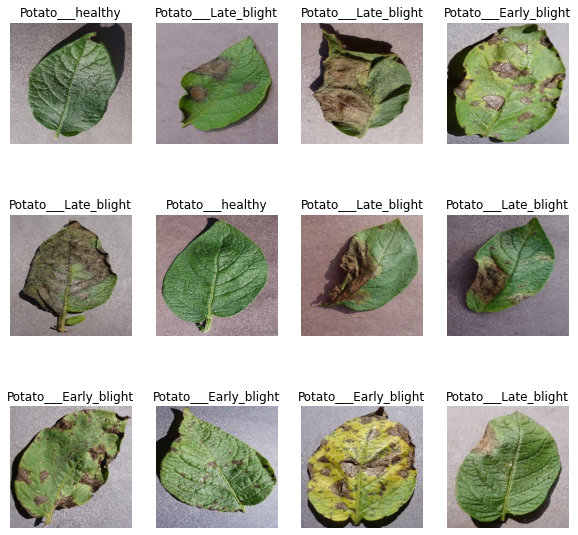

In [64]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
#     print(image_batch[0].numpy())
#     print(label_batch.numpy())

In [65]:
# 80% ==> training 
# 20% ==> 10% validation and 10% test

In [66]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [67]:
train_ds = dataset.take(54)
len(train_ds)

54

In [68]:
test_ds = dataset.skip(54) # skipping first 54 dataset
len(test_ds)

14

In [69]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [70]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [71]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [72]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1,test_split = 0.1, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [74]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

NameError: name 'shuffle' is not defined

In [75]:
len(train_ds)

54

In [76]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [77]:
# preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [78]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2), 
])

In [89]:
# model building
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation= 'relu',input_shape =  input_shape),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64,kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
    
])

model.build(input_shape = input_shape)

In [90]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [92]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
    
)

In [ ]:
model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

In [ ]:
score = model.evaluate(test_ds)